In [42]:
import os
import numpy as np
from numpy import ndarray as Array
from typing import Any, Dict, List, Tuple, Callable
from google.colab import drive
drive.mount('/content/gdrive')
IMAGES_PATH = os.path.join('/content/gdrive/My Drive/',
                           'Documents/IIITB/Courses/Upgrad/xAI/images')
# IMAGES_PATH = os.path.join(os.path.expanduser('~/Projects/UpgradDemos/Images'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
from math import prod


class ImageShapData:
    """Data class for images where xp-space is the superpixel space for the images"""
    def __init__(self,
                 # List of image file names
                 images:List,
                 # Max number of superpixels to segmnet each image into
                 # The SLIC algorithm will try to create as close to n_segments superpixels
                 # as possible
                 n_segments:int=100,
                 # This is for the smoothing applied to the images as part of preprocessing
                 smoothing:float=2.0):
        self.imgs, self.segments = self._images_to_array(images, n_segments, smoothing)
        assert self.imgs.shape[:3] == self.segments.shape, \
                    f'{self.imgs.shape} != {self.segments.shape}'
        # Number of superpixels in each image
        self.n_segments:Array = np.max(self.segments.reshape(self.segments.shape[0], -1),
                                       axis=1)
        self.max_segments = int(np.max(self.n_segments))
        self.x = self.gen_xp_representations_()
        assert self.x.shape == (self.imgs.shape[0], self.max_segments)
        self.n_examples = self.x.shape[0]
        self.image_shape = self.imgs.shape[1:]

    def _images_to_array(self,
                         images:List,
                         n_segments:int,
                         smoothing:float):
        # intended to be a private method
        """Converts the list of images into numeric (pixel values) arrays
        n_segments: number of target superpixels to create
        smoothing: smoothing parameter (sigma) for SLIC
        """
        # load the images and convert them to a floating point data type
        images = [img_as_float(io.imread(os.path.join(IMAGES_PATH, img)))
                  for img in images]
        max_h = max([img.shape[0] for img in images])
        max_w = max([img.shape[1] for img in images])
        x, segments = [], []
        for img in images:
            # Pad all the images with zeros to bring all of them to the same size
            pad_x1 = (max_w - img.shape[1]) // 2
            pad_x2 = (max_w - img.shape[1]) - pad_x1
            pad_y1 = (max_h - img.shape[0]) // 2
            pad_y2 = (max_h - img.shape[0]) - pad_y1
            x.append(np.pad(img, pad_width=((pad_y1, pad_y2), (pad_x1, pad_x2), (0, 0))))
            # apply SLIC and extract (approximately) the supplied number
            # of segments
            seg = slic(img, n_segments=n_segments, sigma=smoothing)
            segments.append(np.pad(seg, pad_width=((pad_y1, pad_y2), (pad_x1, pad_x2))))
        # Combine the individual images and segments into single arrays
        return np.array(x), np.array(segments)

    def extract_segments(self,
                         image_id:int=0,
                         segment_ids:List[int]=None,
                         blank_rest:bool=False):
        segments_only = segment_ids is not None and len(segment_ids) > 0
        img, all_segments = self.imgs[image_id], self.segments[image_id]
        if segments_only:
            # Choose the segments if given
            only_given_segments = np.where(np.isin(all_segments, segment_ids), all_segments, 0)
            if blank_rest:
                # Blank out the rest of the image
                img = img * np.expand_dims(np.where(only_given_segments > 0, 1, 0), axis=2)
            else:
                img = mark_boundaries(img, only_given_segments)
        else:
            img = mark_boundaries(img, all_segments)
        return img

    def show_image(self,
                   image_id:int=0,
                   segment_ids:List[int]=None,
                   blank_rest:bool=False):
        """Display the image with the supplied segment (superpixel) highlighted
        If 'blank_rest' is True, the rest of the image will be blanked out else
        just the choson segment if any will be highlighted
        """
        segments_only = segment_ids is not None and len(segment_ids) > 0
        superpixel_caption = f'Superpixels {segment_ids} of ' if segments_only else ''
        title = f'{superpixel_caption}Image {image_id + 1}'
        fig = plt.figure(title)
        ax = fig.add_subplot(1, 1, 1)
        img = self.extract_segments(image_id, segment_ids, blank_rest)
        ax.imshow(img)
        plt.axis("off")
        plt.title(title)
        plt.show()
        return img

    def xp_labels_(self,
                   idxs: Array) -> Tuple[str]:
        """Index itself is the label"""
        return tuple([('Superpixel ' + str(i)) for i in idxs.tolist()])

    def gen_xp_representations_(self):
        """Generate the xp-representations for each image
        The representation is just a string of 1's because the image by default
        has all the superpixels, except the filler slots at the end to make
        all images of the same size"""
        # This is a vectorized implementation
        return (1 - np.cumsum(np.eye(self.max_segments)[self.n_segments-1], axis=1))

        # =======================================================================
        # Equivalent with a for loop
        # x = np.zeros((self.n, self.max_segments))
        # for i in range(self.n):
        #     # Number of segments for this image
        #     n_segments = self.n_segments[i]
        #     # Fill the number of segments in image 'i' with 1
        #     x[i, :n_segments] = 1
        # return x
        # =======================================================================

    def reverse_map_(self,
                     image_id:int,
                     xp_image:Array) -> Array:
        """Reverse map an image in the superpixel representation to an actual image
        'image_id' contains the index of the original image from which this
        xp_image sample has been created. THe image_id is required to access the
        # segment and pixel information for the original image.
        """
        assert xp_image.shape == (self.max_segments,), \
                    f'{xp_image.shape} != {(self.max_segments,)}'
        # Get the segments info for the original image - The segmeent ids are 1-based
        sample_segments = self.segments[image_id] - 1
        # Get the actual images in the sample
        original_image = self.imgs[image_id]
        # Creates 'self.max_segments' copies of the image without channels, each copy
        # containing the pixels corresponding to exactly one superpixel/segment of the image
        i_segments = np.eye(self.max_segments)[sample_segments]
        # [:2] to ignore the channel dimension if any
        image_dim_without_channels = self.image_shape[:2]
        target_shape = (*image_dim_without_channels, self.max_segments)
        assert i_segments.shape == target_shape, f'{i_segments.shape} != {target_shape}'

        # The two new axes added are for the image dimensions
        # This will select only those pixels belonging to the superpixels present in xp_image
        active_pixels = xp_image[np.newaxis, np.newaxis, :] * i_segments
        active_pixels = np.sum(active_pixels, axis=2)
        assert active_pixels.shape == image_dim_without_channels, \
                    f'{active_pixels.shape} != {image_dim_without_channels}'
        # Add another dimension for the channels and restore the original pixel values
        # Add the sample dimension (dim 0) to the original image
        return active_pixels[:,:,np.newaxis] * original_image

In [44]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet50_Weights
from torchvision import models as pretrained_models, transforms
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda')

class TorchImageDataset(Dataset):
    """Takes care of loading and preprocessing the images"""
    def __init__(self,
                 imgs:Array,
                 reverse_map_fn:Callable):
        super().__init__()
        self.images = imgs
        self.n_images = imgs.shape[0]
        self.reverse_map_fn = reverse_map_fn

        # =================================================================
        # Only for very large images and/or datapoint/samples
        # MemoryMappedTensor --- maps the tensor to a file on the disk
        # which can be accessed as a normal Pytorch array
        # self.images = MemoryMappedTensor.empty(imgs.shape,
        #                                        dtype=torch.float32,
        #                                        prefix=IMAGES_PATH,
        #                                       )
        # =================================================================

        # Define the image transformations that pytorch typically expects
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self): return self.n_images

    def __getitem__(self,
                    idx:int):
        # Conver the superpixel representation back to the pixel representation
        img = self.reverse_map_fn(idx, self.images[idx])
        # Pytorch expects images to be given as (channels, height, width)
        image = torch.from_numpy(np.permute_dims(img, axes=(2, 0, 1))).float().to(DEVICE)
        # Transform the image to make it ready for the model
        if self.transform:
            image = self.transform(image)
        return image

class PytorchModule(nn.Module):
    def __init__(self,
                 model:str):
        super().__init__()
        self.model = nn.Sequential(
            model,
            # Convert model prediction logits into probabilities
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


class TorchImagenetClassificationModel:
    IMAGENET_CATEGORIES = ResNet50_Weights.DEFAULT.meta["categories"]
    # Available pytorch pretrained models on imagenet
    MODELS = {
        "vgg16": pretrained_models.vgg16(pretrained=True),
        "vgg19": pretrained_models.vgg19(pretrained=True),
        "inception": pretrained_models.inception_v3(pretrained=True),
        "densenet": pretrained_models.densenet121(pretrained=True),
        "resnet": pretrained_models.resnet50(pretrained=True)
    }
    IMAGENET_LABELS = dict(enumerate(IMAGENET_CATEGORIES))

    def __init__(self,
                 model:str,
                 batch_size:int=16):
        """Classifier model that gives probabilities for each class"""
        self.model_name = model
        self.model = PytorchModule(self.MODELS[model])
        self.model.to(DEVICE)
        self._print_model_stats()
        self.batch_size = batch_size

    @property
    def n_classes(self): return len(self.IMAGENET_CATEGORIES)

    def _print_model_stats(self):
        # Count the number of parameters
        num_params = sum(p.numel() for p in self.model.parameters())
        print()
        print(f"Number of Model Parameters: {num_params}")

        # Approximate memory usage for weights (float32)
        # This does not include activations, gradients, or optimizer state
        memory_bytes = num_params * 4  # 4 bytes per float32
        memory_mb = memory_bytes / (1024 * 1024)
        print(f"Approximate memory for weights: {memory_mb:.2f} MB")

    def predict_(self,
                 x:Array,
                 reverse_map_fn:Callable) -> Array:
        """Get the model predictions for the datapoints in x"""
        dataloader = DataLoader(TorchImageDataset(x, reverse_map_fn),
                                batch_size=self.batch_size, shuffle=False,
                                drop_last=False)
        # Set the model to evaluation mode
        self.model.eval()
        preds = []
        for batch in tqdm(dataloader, desc='Predictions'):
            # Disable gradient calculation for inference
            with torch.no_grad():
                output = self.model(batch.to(DEVICE))
                preds.append(output)
        return torch.cat(preds).cpu().numpy().astype(float, copy=False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warni

In [45]:
from math import prod
from functools import partial

class Shap:
    def __init__(self,
                 images:ImageShapData,
                 model:TorchImagenetClassificationModel,
                 n_classes_of_interest:int,
                 n_perms:int=10):
        self.images = images
        self.model = model
        self.n_perms = n_perms
        self.n_perms2 = (2 * self.n_perms)
        self.x = self.images.x
        self.n_examples, self.n_features = self.x.shape
        self.n_samples = self.n_examples * self.n_perms
        self.n_samples2 = (2 * self.n_samples)
        self.n_classes_of_interest = n_classes_of_interest

    def generate_coalition_masks(self):
        """Generate the masks used to apply permutations to the features
        - n_perms permutations for each sample and the masks correspond to
        both the l2r and r2l coalitions for every feature"""
        def restore_perm_and_reshape(a:Array):
            a = np.take_along_axis(a, revs, axis=1)
            return np.reshape(a, (self.n_examples, self.n_perms,
                                  self.n_features, self.n_features))

        # Generate 'n_sample' permutations of the features
        idxs = np.tile(np.array([[i for i in np.arange(self.n_features)]]),
                       (self.n_samples, 1))
        rng = np.random.default_rng()
        perms = rng.permuted(idxs, axis=1)

        # Get the inverses of the permutations and  expand it in the feature dimension (dim 2)
        # so the same position permutations are applied to each sample-feature pair
        rev = np.argsort(perms, axis=1)
        assert np.all(idxs == np.take_along_axis(perms, rev, axis=1))
        revs = np.tile(rev[:,:,np.newaxis], (1, 1, self.n_features))

        # perm_mask[i,j,k] will be 1 iff in the i-th permutation (sample),
        # feature k appears in position j. It's a 0-1 array
        # dim 1 of size self.n_features represents features
        # dim 2 of size self.n_features represents a coalition in which the feature can appear
        perm_mask = np.eye(self.n_features)[perms]
        assert perm_mask.shape == (self.n_samples, self.n_features, self.n_features), \
                f'{perm_mask.shape} != {(self.n_samples, self.n_features, self.n_features)}'

        # The 1's in each of the 4 arrays below represent possible coalitions for each
        # sample-feature pair
        # incl - including the feature in the coalition; excl - excluding the feature
        # l2r - the coalition of features following any given feature in the permutation
        # r2l - the coalition of features preceding the feature
        l2r_incl = np.cumsum(perm_mask, axis=1)
        # Subtract perm_mask to set the perm_mask locations back to zero
        l2r_excl = l2r_incl - perm_mask
        # Revert back to the original order of the features and reshape them
        l2r_incl = restore_perm_and_reshape(l2r_incl)
        l2r_excl = restore_perm_and_reshape(l2r_excl)
        # Create the r2l coalitions
        r2l_incl, r2l_excl = (1 - l2r_excl), (1 - l2r_incl)

        # The r2l and l2r coalitions together gives us double the number of samples
        # for each datapoint-feature pair
        incl_mask = np.concatenate([l2r_incl, r2l_incl], axis=1)
        excl_mask = np.concatenate([l2r_excl, r2l_excl], axis=1)
        assert (incl_mask.shape == excl_mask.shape ==
                (self.n_examples, self.n_perms2,
                 self.n_features, self.n_features))

        # Finding the shap weights --- depending on the coalition size (count)
        # Higher the coalition size the higher the weight
        weights = 1.0 / (self.n_features - np.sum(excl_mask, axis=3, dtype=int))
        assert (weights.shape == (self.n_examples, self.n_perms2, self.n_features))
        return incl_mask, excl_mask, weights

    def generate_coalition_samples(self):
        """Generate coalitions of superpixels and the rest filled with zeros
        for each image in 'self.x'. Use the coalition mask to fill
        slots for superpixels not in the coalition with 0.
        For each superpixel, we need samples that include it and also
        samples that exclude it (1's in those slots replaced by 0).
        The coalitions are generated using the permutation method

        The reference values for images are just 0.
        """
        x = np.expand_dims(self.x, axis=(1, 2))

        # Generate the coalition masks
        incl_mask, excl_mask, weights = self.generate_coalition_masks()
        # Apply the coalition masks (of the features) to x and the random samples
        # The 'reference' values for the features outside the coalition come from the
        # random samples and for those in the coalition come from xx
        shap_samples_incl = np.where(incl_mask == 1, x, 0)
        shap_samples_excl = np.where(excl_mask == 1, x, 0)
        return shap_samples_incl, shap_samples_excl, weights

    def reverse_map_func(self,
                         n_samples_per_set:int,
                         set_shape:Tuple[int],
                         idx:int,
                         superpixel_representation:Array):
        set_idx = idx if idx < n_samples_per_set else (idx - n_samples_per_set)
        image_id = np.unravel_index(set_idx, set_shape)[0]
        return self.images.reverse_map_(image_id, superpixel_representation)

    def shap(self):
        """Core Shap algorithm --- will return the shapley values of the superpixels for each image in 'self.images'"""
        # Getting the predictions for the given images
        decision_classes, decision_probs = self.predict_for_images()
        assert self.n_examples == len(decision_classes)
        n_classes = decision_classes.shape[1]
        # Generate the coalition samples
        samples_incl, samples_excl, weights = self.generate_coalition_samples()
        assert samples_incl.shape == samples_excl.shape
        assert samples_incl.shape == (self.n_examples, self.n_perms2,
                                        self.n_features, self.n_features)
        assert weights.shape == (self.n_examples, self.n_perms2,
                                 self.n_features)

        # We will be creating (n_examples * n_preds2 * n_features) images for
        # each explanation datapoint --- this will be extremely memory
        # intensive. So we club all the images together and let the pytorch dataloader
        # process the images in batches to manage memory better. The mapping back to an image
        # from the superpixel representation will be done before the model is called for
        # each individual image. The function reverse_map_func facilitates this. It is

        n_samples_per_set = self.n_samples2 * self.n_features
        set_shape = (self.n_examples, self.n_perms2, self.n_features)

        samples_for_prediction = np.concatenate([samples_incl.reshape(n_samples_per_set,
                                                                      self.n_features),
                                                 samples_excl.reshape(n_samples_per_set,
                                                                      self.n_features)],
                                                axis=0)
        print(f'Predicting for {len(samples_for_prediction)} sample superpixel coalition images ...')
        partial_reverse_map_func = partial(self.reverse_map_func,
                                           n_samples_per_set,
                                           set_shape)
        sample_preds = self.model.predict_(samples_for_prediction,
                                           partial_reverse_map_func)
        # Restore the original indices
        incl_preds = sample_preds[:n_samples_per_set].reshape(*set_shape,
                                                              self.model.n_classes)
        excl_preds = sample_preds[n_samples_per_set:].reshape(*set_shape,
                                                              self.model.n_classes)
        # Get the incremental contributions
        deltas = np.mean((incl_preds - excl_preds), axis=1)
        shap_values = np.take_along_axis(deltas, decision_classes[:, np.newaxis, :], axis=2)
        # Sorting the features in decreasing order of the deltas (shap values)
        feature_indices = np.argsort(shap_values, axis=1)[:, ::-1, :]
        shap_values = np.take_along_axis(shap_values, feature_indices, axis=1)
        assert shap_values.shape == (self.n_examples, self.n_features, n_classes)
        self.shap_plot(feature_indices, shap_values, decision_classes, decision_probs)

    def predict_for_images(self):
        imgs = self.images.x
        partial_reverse_map_func = partial(self.reverse_map_func,
                                           len(imgs),
                                           (len(imgs),))
        pred = self.model.predict_(imgs, partial_reverse_map_func)

        k = self.n_classes_of_interest
        top_k_class_indices = np.argsort(pred, axis=1)[:, -k:].astype(int)
        top_k_class_probs = np.take_along_axis(pred, top_k_class_indices, axis=1)
        for i in range(len(imgs)):
            top_class_indices = list(reversed(top_k_class_indices[i].tolist()))
            print()
            print(f'Top {k} Predictions for Image {i+1}: ',
                [model.IMAGENET_LABELS[f] for f in top_class_indices])
            top_k_probs = [f'{pred[i][f]:.5f}' for f in top_class_indices]
            print(f'Top {k} Prediction Probabilities for Image {i+1}: ', top_k_probs)
            print()
        return top_k_class_indices, top_k_class_probs

    def shap_plot(self,
                  feature_indices:Array,
                  shap_values:Array,
                  decision_classes:Array,
                  decision_probs:Array,
                  n_shortlisted_features:int=4):
        n_examples, n_features, n_classes = shap_values.shape
        assert feature_indices.shape ==shap_values.shape
        assert decision_classes.shape == (n_examples, n_classes)
        for datapoint_id in range(n_examples):
            print()
            print()
            # Showing the plot only for the top decision
            decision_label = self.model.IMAGENET_LABELS[decision_classes[datapoint_id][-1]]
            prob = decision_probs[datapoint_id][-1]
            # Considering the top 4 features in terms of the Shap score
            feature_indices_for_decision = feature_indices[datapoint_id, :, -1].tolist()
            feature_indices_for_decision = feature_indices_for_decision[:n_shortlisted_features]
            shap_values_for_decision = shap_values[datapoint_id, :, -1].tolist()
            shap_values_for_decision = shap_values_for_decision[:n_shortlisted_features]

            print(f'Decision Probability: {prob}')
            print(f'Total Shap Value of the top {n_shortlisted_features} features: '
                  f'{sum(shap_values_for_decision)}')
            print(f'Total Shap Value across all features: '
                  f'{np.sum(shap_values[datapoint_id, :, -1])}')
            print()
            # Get the images --- the original image and the images with only the selected
            # superpixels
            full_image = self.images.extract_segments(datapoint_id)
            feature_images = [self.images.extract_segments(image_id=datapoint_id,
                                                           segment_ids=[(f+1)],
                                                           blank_rest=True)
                              for f in feature_indices_for_decision]
            labels = [f'Superpixel {f+1}' for f in feature_indices_for_decision]
            fig, ax = plt.subplots(2, 3, figsize=(20, 6))
            ax[0, 0].imshow(full_image)
            ax[0, 0].set_title('Full Image')
            ax[0, 0].axis('off')
            for i, f in enumerate(feature_indices_for_decision):
                c = (i+1) if i < 2 else (i-2)
                r = 0 if i < 2 else 1
                ax[r, c].imshow(feature_images[i])
                ax[r, c].set_title(labels[i])
                ax[r, c].axis('off')
            ax[1,2].bar(labels, shap_values_for_decision)
            ax[1,2].set_xlabel('')
            ax[1,2].set_ylabel('Shap Value')
            ax[1,2].set_title(f'Superpixel Shap Score Bar Chart')
            plt.suptitle(f'Shap analysis of the Top Prediction "{decision_label}" of '\
                         f'Model "{self.model.model_name}" '\
                         f'on Image {datapoint_id+1} in terms of '\
                         f'the top {n_shortlisted_features} Superpixels')
            plt.show()


Image Size:  (500, 400, 3)
Max Number of Superpixels:  50
Sample Superpixels for the First Image: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



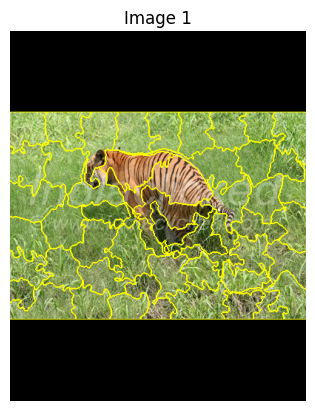

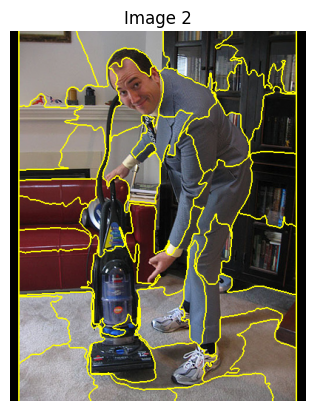


Number of Model Parameters: 27161264
Approximate memory for weights: 103.61 MB


Predictions:   0%|          | 0/1 [00:00<?, ?it/s]


Top 5 Predictions for Image 1:  ['tiger', 'tiger cat', 'jaguar', 'tabby', 'cougar']
Top 5 Prediction Probabilities for Image 1:  ['0.95134', '0.04858', '0.00005', '0.00001', '0.00000']


Top 5 Predictions for Image 2:  ['vacuum', 'beer bottle', 'Loafer', 'can opener', 'plane']
Top 5 Prediction Probabilities for Image 2:  ['0.98559', '0.01024', '0.00104', '0.00059', '0.00045']

Predicting for 4000 sample superpixel coalition images ...


Predictions:   0%|          | 0/334 [00:00<?, ?it/s]



Decision Probability: 0.9513373970985413
Total Shap Value of the top 4 features: 0.8764847950600967
Total Shap Value across all features: 0.9505381388007663



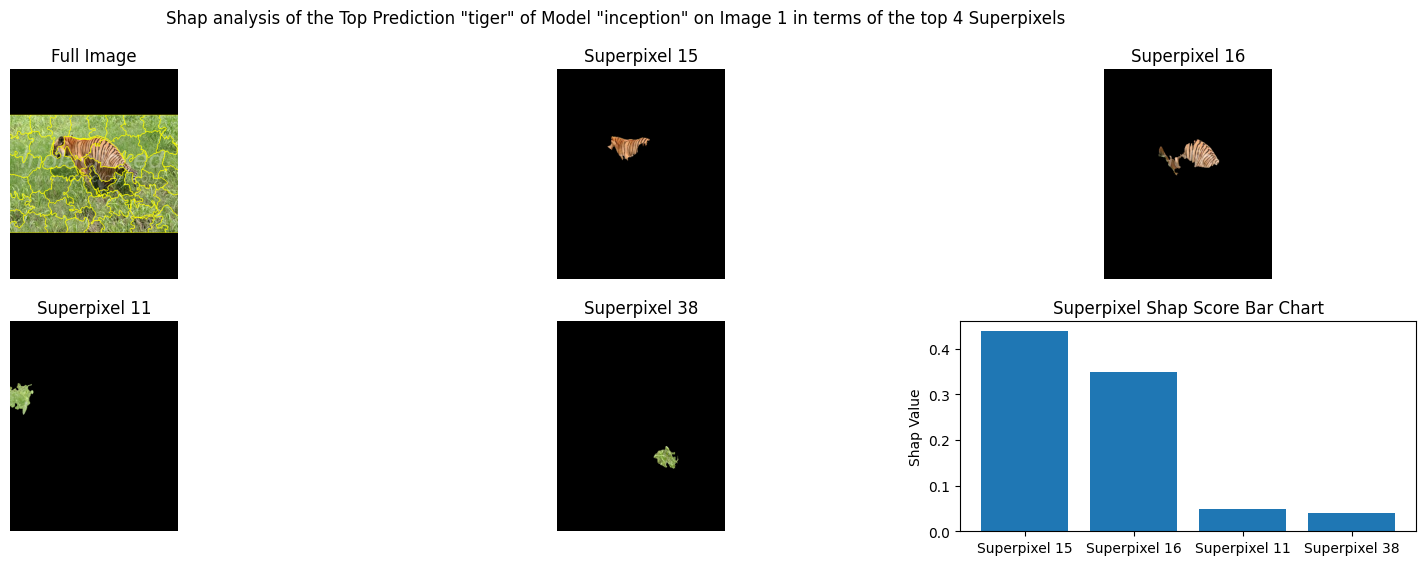



Decision Probability: 0.9855875968933105
Total Shap Value of the top 4 features: 1.0898945241267404
Total Shap Value across all features: 0.9842887368288215



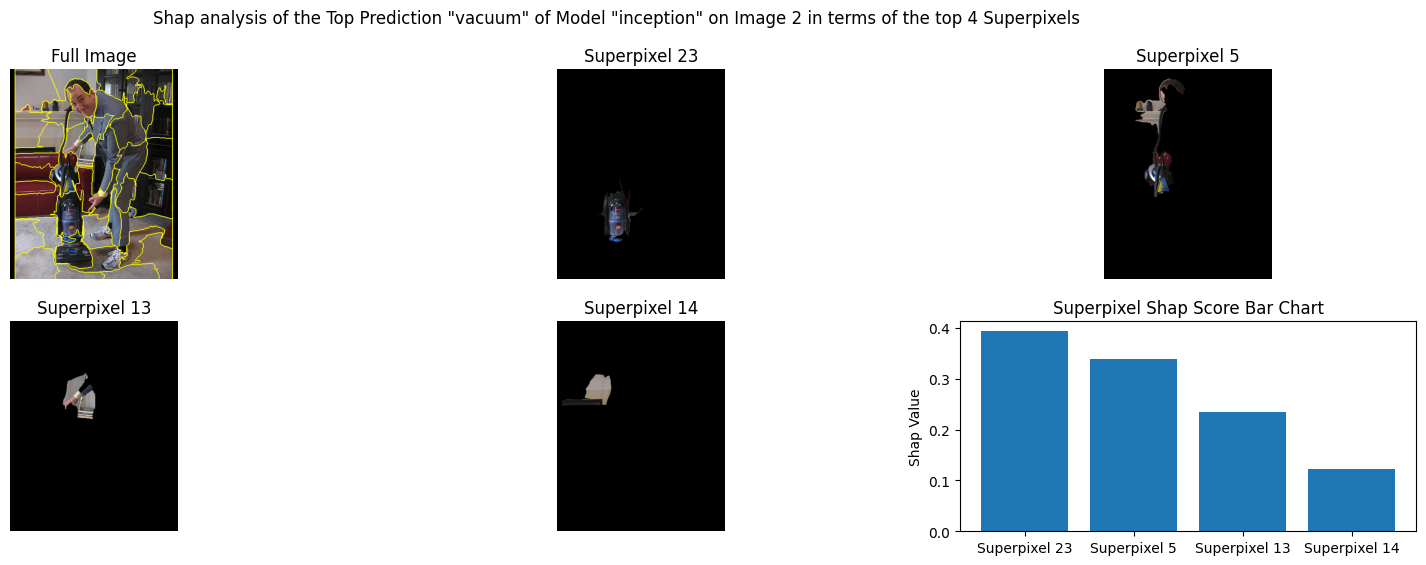

In [46]:
# All tunable parameters
N_SEGMENTS = 50
BATCH_SIZE = 12 # Prediction will be done in batches
N_FEATURES_TO_SHORTLIST = 5
N_CLASSES_OF_INTEREST = 5
N_PERMUTATIONS = 10

img_data = ImageShapData(images=['tiger.JPEG', 'vacuum.JPEG'], n_segments=N_SEGMENTS)
print('Image Size: ', img_data.imgs[0].shape)
print('Max Number of Superpixels: ', img_data.max_segments)
print('Sample Superpixels for the First Image: ')
print(img_data.segments[0])
print()
img_data.show_image()
print()
img_data.show_image(1)
model = TorchImagenetClassificationModel(model="inception", batch_size=BATCH_SIZE)

# Running Shap on the image and the predictions
shap = Shap(images=img_data, model=model,
            n_classes_of_interest=N_CLASSES_OF_INTEREST,
            n_perms=N_PERMUTATIONS)
shap.shap()